TPOT regression for the car prices (homework 1).

In [1]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=1312ce75e5834956e7743b37862f18507ca5d59701e3710a47cec8b64400cece
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [12]:
# импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder

from tpot import TPOTRegressor

In [13]:
# load data
data = pd.read_csv('https://raw.githubusercontent.com/Alexandre-aksenov/predict-car-prices-using-H2O-tpot/main/ToyotaCorolla.csv')

print(data.shape)  # (1436, 10)

(1436, 10)


In [14]:
data.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


Encode the categorical variable 'FuelType' as 0,1,2.

In [16]:
# https://stackoverflow.com/a/56502961
enc = OrdinalEncoder()

# data['FuelType']  = enc.fit_transform(data['FuelType'])
# Error! Expected 2D array, got 1D array instead:
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature

data[['FuelType']]  = enc.fit_transform(data[['FuelType']])

data.head()  # OK!

# 'Diesel' is replaced by 1.0, as it goes after 'CNG' in alphabet.

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170


array([[<Axes: title={'center': 'discr_price'}>]], dtype=object)

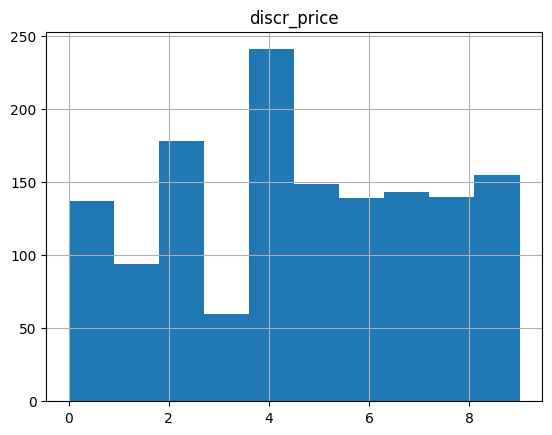

In [17]:
# Specify the target variable.

target = [data.columns[0]]

# train-test split.
# sklearn is used for stratification, making sure that the subdivision is the same
# as for the linear regression.

# N.B. Possile improvement.
# This stratified subdivision in case of continuous variable can be transformed into a function,
# or it would be event better if this function can be found.

# Prototype.
# data, params of KBinsDiscretizer , params of train_test_split
# -> data_train, data_test


price_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal')
#  default strategy : 'quantile'

y_discretized = price_discretizer.fit_transform(data[target])
discrete_target = ['discr_price']

data[discrete_target] = y_discretized

data[discrete_target].hist()

# the extra column 'discr_price' should be removed after train-test split.

In [18]:
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['discr_price'], random_state=42)

# removing the extra column 'discr_price'.
data_train.drop(columns=discrete_target, inplace=True)
data_test.drop(columns=discrete_target, inplace=True)

print(data_train.shape)  # (1148, 10)
print(data_test.shape)   #  (288, 10)

# end of the function

X_train = data_train.drop(columns=target, inplace=False)
X_test = data_test.drop(columns=target, inplace=False)
print(X_train.shape)  # (1148, 9)
print(X_test.shape)   # (288, 9)

(1148, 10)
(288, 10)
(1148, 9)
(288, 9)


TPOT regression

In [19]:
tpot = TPOTRegressor(generations=2, verbosity=2, max_time_mins=0.5, random_state=42)

tpot.fit(X_train, data_train[target])

# DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
# y = column_or_1d(y, warn=True)

# TPOT closed prematurely. Will use the current best pipeline.
# Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.55, min_samples_leaf=2, min_samples_split=17, n_estimators=100)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


0.50 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.55, min_samples_leaf=2, min_samples_split=17, n_estimators=100)


TPOTRegressor(generations=2, max_time_mins=0.5, random_state=42, verbosity=2)

Exporting the results.

In [20]:
print(tpot.score(X_test, data_test[target]))  #  -1428054 (== -MSE )
# see: https://epistasislab.github.io/tpot/api/#tpotregressor-score

tpot.export('TPOT_regression.py')

-1428054.084254198


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
pred_price = tpot.predict(X_test)

print(type(pred_price))  # 'numpy.ndarray'
print(pred_price.shape)  # (288,)
# pred_price.head()
print(pred_price[0:10])

<class 'numpy.ndarray'>
(288,)
[10178.89251453  7484.67019075 12502.25291394 14934.04173261
 15823.57332902  8337.54311435  8511.42410845  9816.84862244
  8468.89281445  8308.91641191]


In [23]:
from sklearn.metrics import mean_squared_error
# metrics of quality of the fit

# df_pred_price = pred_price.as_data_frame()
rmse_test = mean_squared_error(data_test[target], pred_price, squared= False)
print("RMSE of the TPOT regression:", rmse_test)  #  1592 $ (lin reg) -> 1195 $
# This number equals indeed the square root of the score produced above.  

RMSE of the TPOT regression: 1195.012169082055


Looking for the exported file

In [ ]:
%ls
# sample_data/  TPOT_regression.py

In [25]:
from google.colab import files

In [26]:
files.download('TPOT_regression.py')
# This python module is joined to the repository.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TPOT provides indeed an improvement over the linear regression despite it being given only 30s for computation. 